In [23]:
#|default_exp challange/base

# Resnet18d working

In [1]:
#| export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.challange.ct94ep5 import *
from miniai.utils import *
from miniai.accel import *
import timm

In [2]:
from miniai.utils import RNG

In [3]:
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.deterministic = False 

In [4]:
#| export
from fastcore.test import test_close
from torch import distributions

def setup_fasion_mnist(seed=1):
    global RNG
    torch.set_printoptions(precision=8, linewidth=140, sci_mode=False)
    mpl.rcParams['image.cmap'] = 'gray'

    import logging
    logging.disable(logging.WARNING)

    if fc.defaults.cpus>8: fc.defaults.cpus=8

    global RNG
    RNG.set_seed(1)

    xl,yl = 'image','label'
    name = "fashion_mnist"
    xmean,xstd = 0.28, 0.35

    @inplace
    def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

    dsd = load_dataset(name)
    tds = dsd.with_transform(transformi)
    tds.cached = cache_dataset_as_dict(tds)
    return tds
    

## run

In [13]:
#| export
import functools
def multi_kw(f):
    @functools.wraps(f)
    def kw(*dicts, **kwargs):
        r = {}
        for d in (*dicts, kwargs):
            for k, v in d.items():
                if k in r and isinstance(r, (list, tuple)): 
                    r[k] = [*r[k], *v]
                elif k not in r:
                    r[k] = v
                else:
                    print(f"duplicate key {k} ")
        return f(**r)
    return kw

@multi_kw
def run(model, leaky=0.0, m=1, cbs=tuple(), fit=True, train_cb=MixedPrecision(), epochs=5, base_lr=2e-2, 
        loss_func=F.cross_entropy, bs=256, tta=False, dls=None, verbose=False, 
        sched_fn=lr_scheduler.OneCycleLR, opt_func=optim.AdamW, tds=None):
    from miniai.utils import RNG
    metrics = LazyMetricsCB(accuracy=MulticlassAccuracy())
    iw = partial(init_weights, leaky=leaky) if leaky is not None else fc.noop
    lr = base_lr*m
    print("Batch size", bs*m)
    dls = dls or DataLoaders.from_dd(tds, bs*m, num_workers=0) 
    tmax = epochs * len(dls.train)
    sched = partial(sched_fn, max_lr=lr, total_steps=tmax)

    cbs = [DeviceCB(), RNG, metrics, BatchSchedCB(sched), *cbs, train_cb] 
    learn = Learner(model.apply(iw), dls, loss_func, lr=lr, cbs=cbs, opt_func=opt_func)
    learn.train_cb = train_cb
    if verbose: 
        print(torch.randn([3]))
        print(next(iter(learn.dls.train))[1])
    if fit:
        learn.fit(epochs, cbs=[TimeItCB(), LazyProgressCB(plot=epochs>1)])
    if tta:
        ## TTA
        ap1, at = learn.capture_preds()
        ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
        ap2, at = learn.capture_preds(cbs=[ttacb])
        ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
        print('TTA:', round((ap==at).float().mean().item(), 4))
    return learn

In [7]:
tds = setup_fasion_mnist()

Reseed: 1


  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
run = partial(run, leaky=0.0, train_cb=MixedPrecision(), epochs=5, base_lr=2e-2, loss_func=F.cross_entropy, bs=256, sched_fn=lr_scheduler.OneCycleLR, opt_func=optim.AdamW, tds=tds.cached)

In [20]:
run

functools.partial(<function run at 0x7f43f75b4ca0>, tds={ train: (#60000), test: (#10000) }, leaky=0.0, m=1, cbs=(), fit=True, train_cb=<miniai.accel.MixedPrecision object at 0x7f43f7fef5e0>, epochs=5, base_lr=0.02, loss_func=<function cross_entropy at 0x7f44f4935360>, bs=256, tta=False, dls=None, verbose=False, sched_fn=<class 'torch.optim.lr_scheduler.OneCycleLR'>, opt_func=<class 'torch.optim.adamw.AdamW'>)

### Setup base model from 13_resnet

In [8]:
#| export
# The last resnet model 92.8% 5epochs
def model_base_resnet():
    def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
        layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
        layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
        layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
        return nn.Sequential(*layers).to(def_device)
    RNG.previous()
    act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
    
    return dict(model=get_model(act_gr, norm=nn.BatchNorm2d), leaky=0.1)

Reseed: 2
Reseed: 2
Batch size 1024
Reseed: 2


accuracy,loss,epoch,train
0.804,0.743,0,train
0.817,0.614,0,eval
0.891,0.355,1,train
0.892,0.333,1,eval
0.915,0.257,2,train
0.889,0.318,2,eval
0.934,0.198,3,train
0.924,0.222,3,eval
0.955,0.143,4,train
0.928,0.216,4,eval


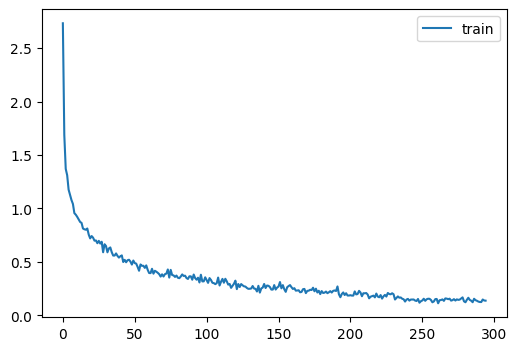

Fit 5 in: 14.64s, setup: 0.00s, 2.78 ± 0.44s per epoch, 0.02 ± 0.06s per batch


In [12]:
RNG.set_seed(2)
learn = run(**model_base_resnet(), bs=1024, base_lr=2e-2, train_cb=TrainCB())

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.842,0.612,0,train
0.868,0.422,0,eval
0.891,0.335,1,train
0.893,0.324,1,eval
0.914,0.249,2,train
0.900,0.283,2,eval
0.935,0.191,3,train
0.926,0.209,3,eval
0.953,0.139,4,train
0.932,0.196,4,eval


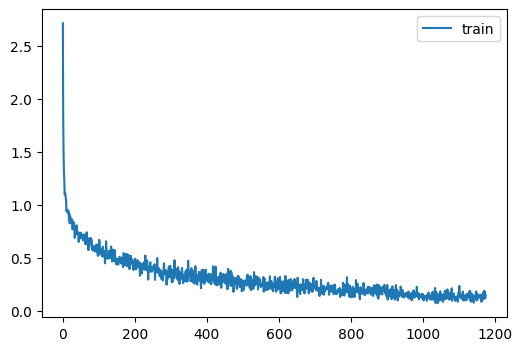

Fit 5 in: 20.34s, setup: 0.00s, 3.87 ± 0.02s per epoch, 0.01 ± 0.00s per batch


In [13]:
RNG.set_seed(1)
learn = run(**model_base_resnet(), base_lr=1e-2, train_cb=TrainCB())

### Upscale for resnet

In [12]:
#| export
class Upscale:
    def __init__(self, sz, align=True, const=0): fc.store_attr() 
    def _sz(self, n): return round(self.sz*n / 32)*32 if self.align else self.sz*n
    def antialiased(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.BILINEAR, antialias=True)
    def bilinear(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.BILINEAR, antialias=False)
    def bicubica(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.BICUBIC, antialias=True)
    def bicubic(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.BICUBIC, antialias=False)
    def nearest(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.NEAREST)
    def pad(self, n): 
        return transforms.Pad((self._sz(n)-self.sz)//2, padding_mode='constant', fill=self.const)

In [13]:
#|export
upscale32 = Upscale(28, align=True, const=-0.800000011920929)
upscale = Upscale(28, align=False, const=-0.800000011920929)

In [11]:
RNG.previous()
learn = run(model=get_model(), epochs=1)
xb,yb = learn.batch

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.795,0.580,0,train
0.859,0.375,0,eval


Fit 1 in: 2.73s, setup: 0.00s, 2.67 ± 0.00s per epoch, 0.01 ± 0.10s per batch


In [12]:
xb.shape, upscale32.bilinear(4)(xb).shape,upscale32.pad(4)(xb).shape

(torch.Size([272, 1, 28, 28]),
 torch.Size([272, 1, 128, 128]),
 torch.Size([272, 1, 128, 128]))

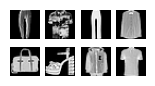

In [13]:
def show_actual_size(ims):
    sz = ims.shape[-1]
    show_images(ims, imsize=sz / 64)
show_actual_size(xb[:8])

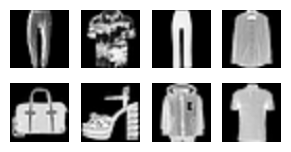

In [14]:
show_actual_size(upscale.bilinear(2)(xb)[:8])

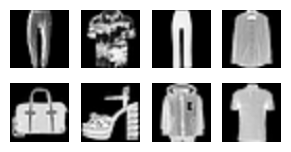

In [15]:
show_actual_size(upscale.bilinear(2)(upscale.bilinear(2)(xb))[:8])

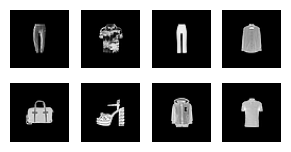

In [16]:
show_actual_size(upscale.pad(2)(xb)[:8])

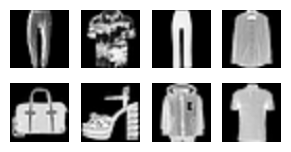

In [17]:
show_actual_size(upscale.antialiased(2)(xb)[:8])

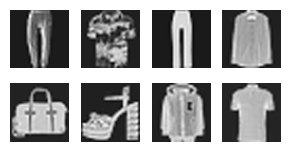

In [18]:
show_actual_size(upscale.bicubic(2)(xb)[:8])

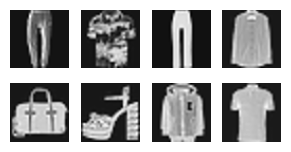

In [19]:
show_actual_size(upscale.bicubica(2)(xb)[:8])

### Timm model upscale, pad, vs noop

> Changes in batchsize does not have any significant impact on training speed

In [20]:
#| export
def timm_model(name, resize=nn.Identity(), leaky=0.0, **kw):
    """ Timm model with no pretraining and upscaling, resnet18d trains at 94.2% 5ep, noaug"""
    RNG.previous()
    props = dict(in_chans=1, num_classes=10, pretrained=False)
    props.update(kw)
    model = nn.Sequential( 
        resize,
        timm.create_model(name, **props)
    )
    return dict(model=model, leaky=leaky)

In [21]:
#| export

def model9_ct(**kw):
    """ Cristopher Thomas 94.9% 5epochs, trains at 94.2% 5ep, noaug, 1ep 0.913 in 17s (vs 7s resnet)"""
    from miniai.challange.ct94ep5 import get_model9
    RNG.previous()
    return dict(model=get_model9(Mish, norm=nn.BatchNorm2d), base_lr=1e-2, leaky=0.0003) | kw

### Select resnet scale

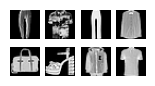

In [13]:
def show_actual_size(ims):
    sz = ims.shape[-1]
    show_images(ims, imsize=sz / 64)
show_actual_size(xb[:8])

In [107]:
learn = run(timm_model('resnet18d', nn.Identity(), leaky=0.0), epochs=1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.721,0.812,0,train
0.838,0.446,0,eval


Fit 1 in: 4.82s, setup: 0.00s, 4.71 ± 0.00s per epoch, 0.02 ± 0.01s per batch


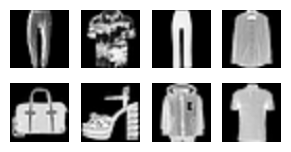

In [14]:
show_actual_size(upscale.bilinear(2)(xb)[:8])

In [51]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, epochs=1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.848,0.430,0,train
0.911,0.240,0,eval


Fit 1 in: 6.65s, setup: 0.00s, 6.42 ± 0.00s per epoch, 0.03 ± 0.00s per batch


In [50]:
learn = run(timm_model('resnet18d', upscale32.nearest(2)), leaky=0.0, epochs=1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.847,0.434,0,train
0.911,0.241,0,eval


Fit 1 in: 6.64s, setup: 0.00s, 6.42 ± 0.00s per epoch, 0.03 ± 0.00s per batch


In [92]:
learn = run(timm_model('resnet18d', upscale32.bicubic(2)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.847,0.435,0,train
0.911,0.241,0,eval


Fit 1 in: 6.85s, setup: 0.00s, 6.62 ± 0.00s per epoch, 0.03 ± 0.01s per batch


In [93]:
learn = run(timm_model('resnet18d', upscale32.bicubica(2)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.849,0.432,0,train
0.910,0.243,0,eval


Fit 1 in: 6.66s, setup: 0.00s, 6.43 ± 0.00s per epoch, 0.03 ± 0.00s per batch


In [94]:
learn = run(timm_model('resnet18d', upscale32.bicubic(4)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.832,0.479,0,train
0.911,0.249,0,eval


Fit 1 in: 17.25s, setup: 0.00s, 16.54 ± 0.00s per epoch, 0.07 ± 0.00s per batch


In [95]:
learn = run(timm_model('resnet18d', upscale32.bilinear(4)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.828,0.492,0,train
0.908,0.257,0,eval


Fit 1 in: 17.47s, setup: 0.00s, 16.77 ± 0.00s per epoch, 0.07 ± 0.02s per batch


In [96]:
learn = run(timm_model('resnet18d', upscale32.nearest(4)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.831,0.483,0,train
0.909,0.251,0,eval


Fit 1 in: 17.37s, setup: 0.00s, 16.68 ± 0.00s per epoch, 0.07 ± 0.01s per batch


In [110]:
learn = run(timm_model('resnet18d', upscale32.pad(2)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.709,0.913,0,train
0.822,0.506,0,eval


Fit 1 in: 6.93s, setup: 0.00s, 6.71 ± 0.00s per epoch, 0.03 ± 0.02s per batch


In [52]:
learn = run(model_base_resnet(), epochs=1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.859,0.461,0,train
0.899,0.287,0,eval


Fit 1 in: 4.23s, setup: 0.00s, 4.13 ± 0.00s per epoch, 0.02 ± 0.00s per batch


In [53]:
learn = run(model9_ct(), epochs=1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.875,0.448,0,train
0.913,0.278,0,eval


Fit 1 in: 17.81s, setup: 0.00s, 16.97 ± 0.00s per epoch, 0.07 ± 0.00s per batch


### 5 Epoch

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.848,0.561,0,train
0.845,0.458,0,eval
0.891,0.320,1,train
0.875,0.405,1,eval
0.912,0.248,2,train
0.908,0.265,2,eval
0.931,0.194,3,train
0.924,0.210,3,eval
0.950,0.142,4,train
0.933,0.192,4,eval


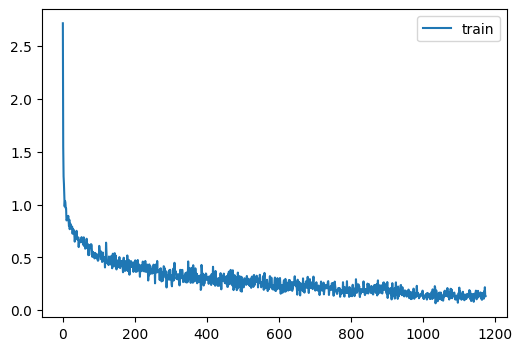

Fit 5 in: 22.24s, setup: 0.00s, 4.27 ± 0.14s per epoch, 0.02 ± 0.00s per batch


In [46]:
RNG.set_seed(1)
learn = run(model_base_resnet())

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.837,0.474,0,train
0.652,1.057,0,eval
0.904,0.265,1,train
0.906,0.271,1,eval
0.926,0.201,2,train
0.902,0.275,2,eval
0.947,0.145,3,train
0.933,0.192,3,eval
0.967,0.092,4,train
0.942,0.173,4,eval


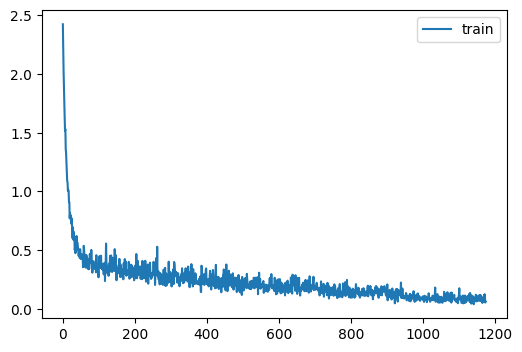

Fit 5 in: 34.43s, setup: 0.00s, 6.58 ± 0.08s per epoch, 0.03 ± 0.00s per batch


In [66]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.868,0.543,0,train
0.878,0.394,0,eval
0.909,0.289,1,train
0.891,0.344,1,eval
0.930,0.208,2,train
0.919,0.230,2,eval
0.952,0.145,3,train
0.936,0.187,3,eval
0.975,0.082,4,train
0.942,0.183,4,eval


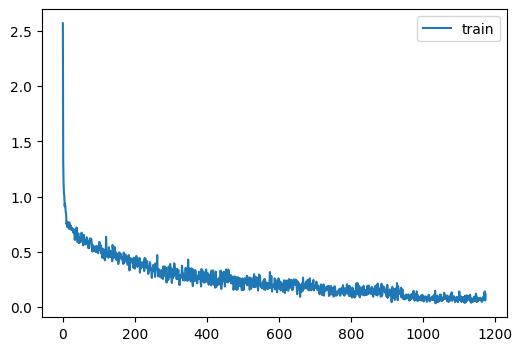

Fit 5 in: 96.07s, setup: 0.00s, 17.25 ± 0.10s per epoch, 0.07 ± 0.01s per batch


In [67]:
learn = run(model9_ct())

## Curriculum learning on FP16

> It doesn't make a difference for fp16

In [22]:
def curriculum():
    return dict(dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0), 
                cbs=[TopLossesCallback(n={
            0: 0,
            1: 0.21,
            2: 0.42,
            3: 0.21,
            4: 0
    })])

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.849,0.561,0,train
0.868,0.400,0,eval
0.818,0.489,1,train
0.749,0.649,1,eval
0.815,0.476,2,train
0.859,0.346,2,eval
0.880,0.304,3,train
0.926,0.215,3,eval
0.974,0.084,4,train
0.935,0.203,4,eval


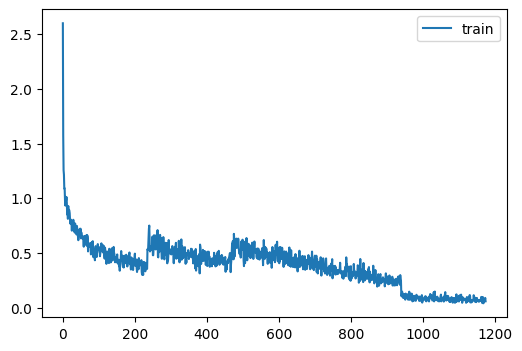

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Replacing top 12600 expamples out of 60000
Replacing top 25200 expamples out of 60000
Replacing top 12600 expamples out of 60000
Fit 5 in: 23.24s, setup: 0.00s, 4.39 ± 0.15s per epoch, 0.02 ± 0.01s per batch


In [56]:
learn = run(model_base_resnet(), curriculum(), epochs=5)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.865,0.553,0,train
0.878,0.394,0,eval
0.853,0.421,1,train
0.913,0.257,1,eval
0.878,0.335,2,train
0.928,0.213,2,eval
0.964,0.113,3,train
0.937,0.226,3,eval
0.998,0.024,4,train
0.940,0.221,4,eval


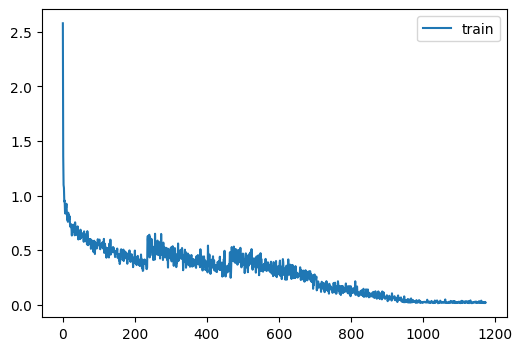

Replacing top 12600 expamples out of 60000
Replacing top 25200 expamples out of 60000
Replacing top 12600 expamples out of 60000
Fit 5 in: 90.92s, setup: 0.00s, 17.26 ± 0.12s per epoch, 0.07 ± 0.01s per batch


In [57]:
learn = run(model9_ct(), curriculum())

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.833,0.483,0,train
0.874,0.374,0,eval
0.847,0.407,1,train
0.913,0.240,1,eval
0.858,0.363,2,train
0.919,0.227,2,eval
0.936,0.165,3,train
0.937,0.227,3,eval
0.994,0.019,4,train
0.941,0.240,4,eval


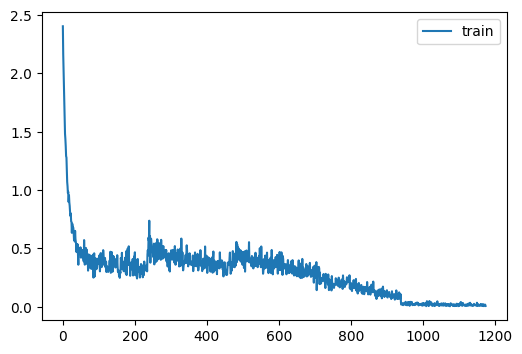

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Replacing top 12600 expamples out of 60000
Replacing top 25200 expamples out of 60000
Replacing top 12600 expamples out of 60000
Fit 5 in: 35.29s, setup: 0.00s, 6.73 ± 0.13s per epoch, 0.03 ± 0.01s per batch


In [43]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,),  curriculum())

### Resnet with augment & curriculum learning

In [16]:
#|export
class DelayedBatchTransformCB(BatchTransformCB):
    def __init__(self, *args,epoch=0,**kwargs): 
        super().__init__(*args, **kwargs)
        self.epoch=epoch
    def before_batch(self, learn):
        if self.epoch <= learn.epoch: 
            super().before_batch(learn)
        
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])
def get_augcb(*ag, delay=0):
    tfms = nn.Sequential(*ag)
    return dict(cbs=[DelayedBatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False, epoch=delay)])

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.827,0.502,0,train
0.779,0.708,0,eval
0.896,0.285,1,train
0.857,0.399,1,eval
0.920,0.219,2,train
0.900,0.263,2,eval
0.938,0.168,3,train
0.931,0.184,3,eval
0.956,0.119,4,train
0.939,0.172,4,eval


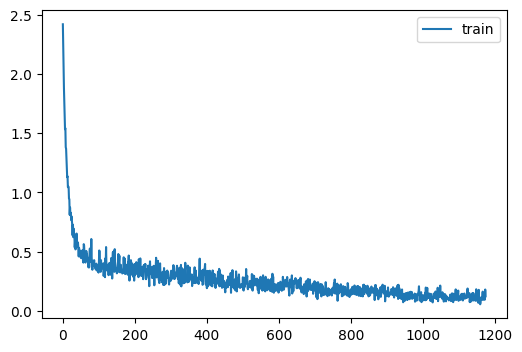

Fit 5 in: 34.38s, setup: 0.00s, 6.57 ± 0.01s per epoch, 0.03 ± 0.00s per batch


In [36]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(transforms.RandomHorizontalFlip(0.5)))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.812,0.533,0,train
0.837,0.515,0,eval
0.888,0.302,1,train
0.888,0.340,1,eval
0.914,0.232,2,train
0.909,0.250,2,eval
0.932,0.181,3,train
0.932,0.189,3,eval
0.949,0.139,4,train
0.938,0.174,4,eval


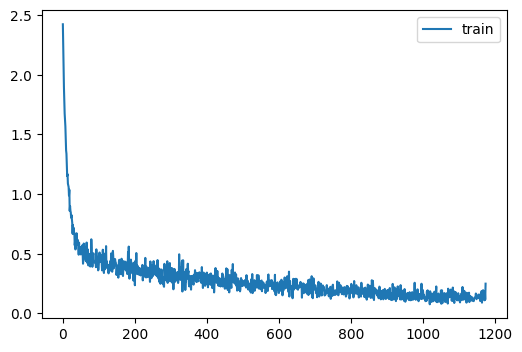

Fit 5 in: 34.47s, setup: 0.00s, 6.59 ± 0.10s per epoch, 0.03 ± 0.01s per batch


In [30]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0), get_augcb(transforms.RandomCrop(28, padding=1)))

In [33]:
xb[0,0,0,0].item()

-0.800000011920929

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.810,0.536,0,train
0.870,0.365,0,eval
0.889,0.302,1,train
0.873,0.366,1,eval
0.913,0.235,2,train
0.916,0.234,2,eval
0.933,0.182,3,train
0.936,0.184,3,eval
0.948,0.141,4,train
0.941,0.171,4,eval


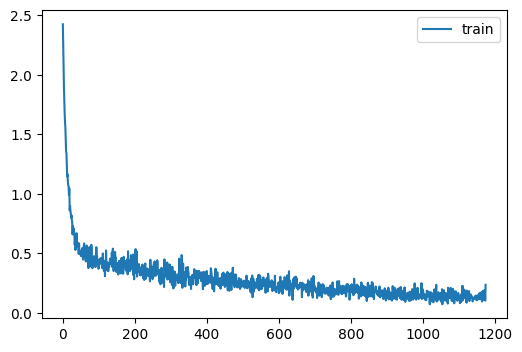

Fit 5 in: 35.79s, setup: 0.00s, 6.85 ± 0.73s per epoch, 0.03 ± 0.05s per batch


In [15]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0), get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929)))

In [93]:
upscale32.bilinear(2)(xb).shape

torch.Size([272, 1, 64, 64])

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


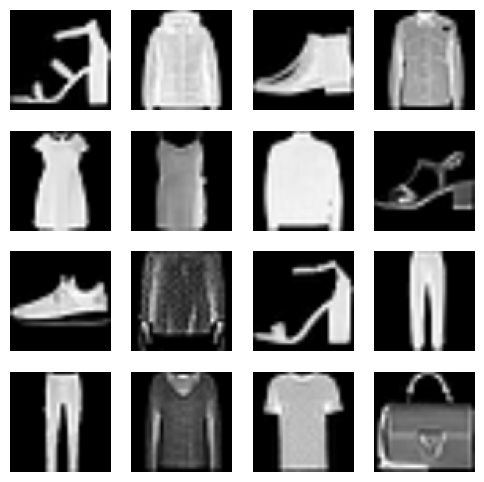

In [18]:
RNG.set_seed(1)
run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0), 
    get_augcb(upscale32.bilinear(2),
             transforms.RandomCrop(64, padding=1, fill=-0.800000011920929)), fit=False).show_image_batch(max_n=16, imsize=(1.5))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.829,0.493,0,train
0.808,0.539,0,eval
0.898,0.279,1,train
0.905,0.273,1,eval
0.921,0.214,2,train
0.916,0.238,2,eval
0.942,0.158,3,train
0.932,0.193,3,eval
0.958,0.114,4,train
0.941,0.169,4,eval


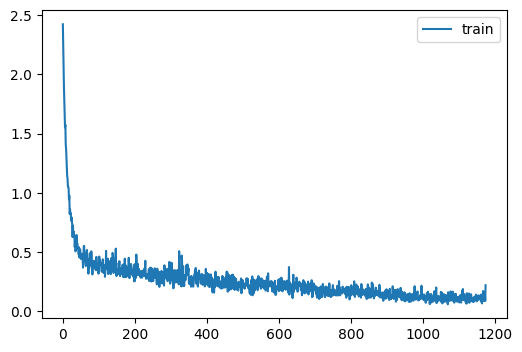

Fit 5 in: 34.35s, setup: 0.00s, 6.57 ± 0.06s per epoch, 0.03 ± 0.00s per batch


In [19]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0), 
            get_augcb(upscale32.bilinear(2),
                      transforms.RandomCrop(64, padding=1, fill=-0.800000011920929)))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.801,0.567,0,train
0.679,1.628,0,eval
0.885,0.318,1,train
0.858,0.438,1,eval
0.909,0.247,2,train
0.901,0.287,2,eval
0.929,0.192,3,train
0.928,0.202,3,eval
0.943,0.155,4,train
0.938,0.173,4,eval


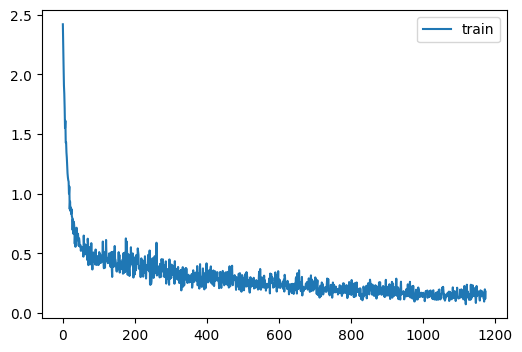

Fit 5 in: 34.79s, setup: 0.00s, 6.66 ± 0.13s per epoch, 0.03 ± 0.01s per batch


In [37]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929), transforms.RandomHorizontalFlip(0.5)))

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


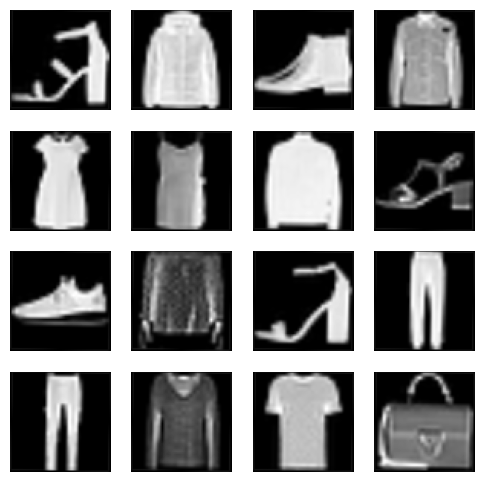

In [20]:
RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=0.0),
            get_augcb(
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
            ), fit=False)
learn.show_image_batch(max_n=16, imsize=(1.5))

In [21]:
learn.fit(5, cbs=ProgressCB())

Reseed: 1


accuracy,loss,epoch,train
0.839,0.464,0,train
0.763,0.800,0,eval
0.900,0.273,1,train
0.871,0.381,1,eval
0.924,0.207,2,train
0.916,0.231,2,eval
0.944,0.152,3,train
0.930,0.195,3,eval
0.964,0.099,4,train
0.937,0.182,4,eval


Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.833,0.482,0,train
0.417,7.805,0,eval
0.903,0.267,1,train
0.132,19.767,1,eval
0.926,0.203,2,train
0.450,7.190,2,eval
0.946,0.149,3,train
0.245,13.420,3,eval
0.966,0.094,4,train
0.800,1.032,4,eval


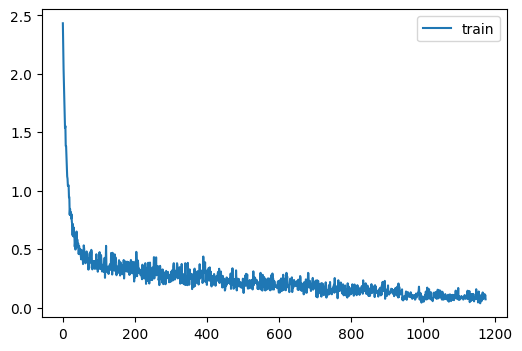

Fit 5 in: 34.21s, setup: 0.00s, 6.54 ± 0.12s per epoch, 0.03 ± 0.01s per batch


In [37]:
RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=0.0),
            get_augcb(
                transforms.RandomAutocontrast(),
            ))

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.814,0.539,0,train
0.391,5.528,0,eval
0.889,0.305,1,train
0.780,0.735,1,eval
0.910,0.241,2,train
0.684,1.468,2,eval
0.933,0.181,3,train
0.482,2.648,3,eval
0.952,0.128,4,train
0.901,0.284,4,eval


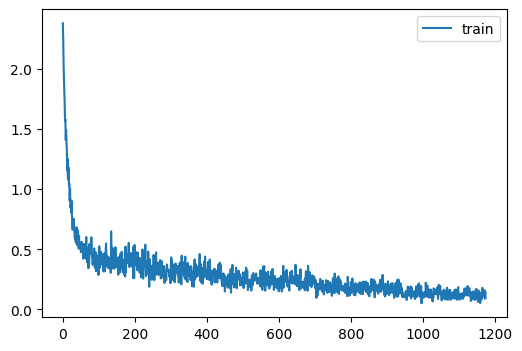

Fit 5 in: 34.43s, setup: 0.00s, 6.58 ± 0.09s per epoch, 0.03 ± 0.00s per batch


In [30]:
RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=0.0),
            get_augcb(
                upscale32.bilinear(2),
                transforms.RandomAdjustSharpness(2),
            ))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.798,0.568,0,train
0.736,0.824,0,eval
0.880,0.328,1,train
0.862,0.415,1,eval
0.908,0.250,2,train
0.870,0.372,2,eval
0.927,0.197,3,train
0.929,0.201,3,eval
0.942,0.157,4,train
0.934,0.182,4,eval


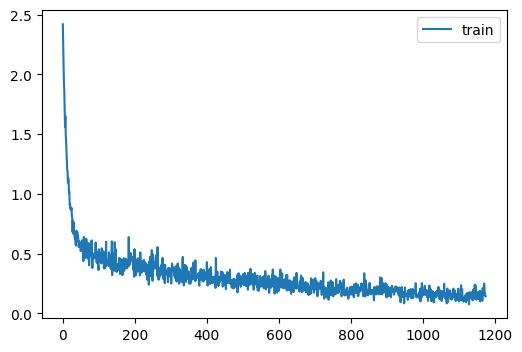

Fit 5 in: 35.85s, setup: 0.00s, 6.87 ± 0.12s per epoch, 0.03 ± 0.01s per batch


In [41]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5)))

## 20 epochs

###  94.87 with rotation1

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.811,0.541,0,train
0.853,0.397,0,eval
0.880,0.325,1,train
0.872,0.366,1,eval
0.894,0.287,2,train
0.862,0.364,2,eval
0.904,0.262,3,train
0.868,0.371,3,eval
0.908,0.247,4,train
0.904,0.258,4,eval


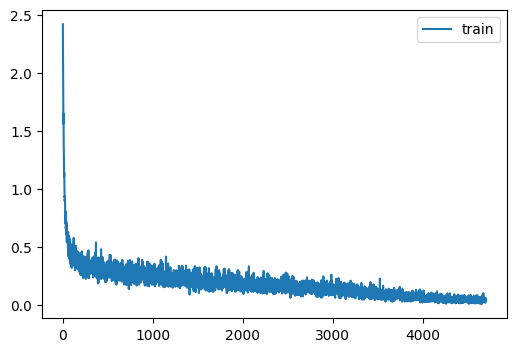

Fit 20 in: 142.82s, setup: 0.00s, 6.83 ± 0.06s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9487


In [44]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5)), epochs=20, tta=True)

###  94.92 with rotation1 + RandErase 0.2

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.783,0.621,0,train
0.836,0.466,0,eval
0.862,0.374,1,train
0.860,0.410,1,eval
0.879,0.330,2,train
0.874,0.358,2,eval
0.890,0.298,3,train
0.896,0.294,3,eval
0.897,0.279,4,train
0.903,0.289,4,eval


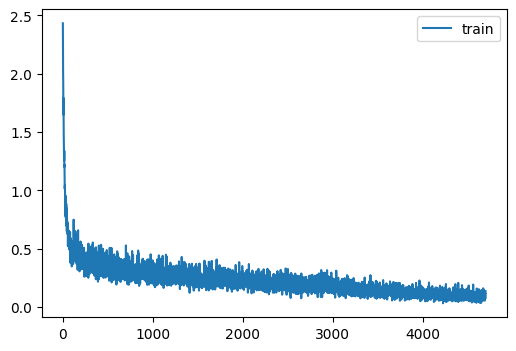

Fit 20 in: 144.61s, setup: 0.00s, 6.93 ± 0.05s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9492


In [46]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase()), epochs=20, tta=True)

###  94.52 with rotation1 + RandErase 0.4

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.719,0.784,0,train
0.819,0.593,0,eval
0.812,0.507,1,train
0.766,0.722,1,eval
0.836,0.440,2,train
0.778,0.796,2,eval
0.855,0.394,3,train
0.847,0.450,3,eval
0.861,0.373,4,train
0.681,1.059,4,eval


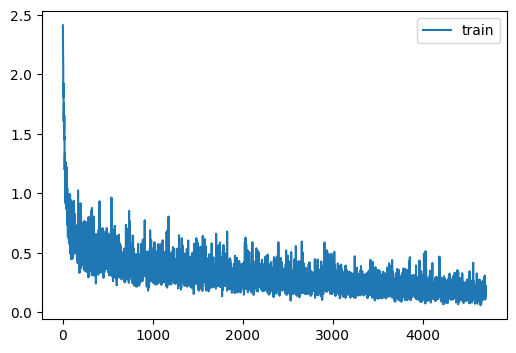

Fit 20 in: 143.99s, setup: 0.00s, 6.90 ± 0.07s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9452


In [48]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.4)), epochs=20, tta=True)

###  94.83 with rotation1 + RandErase 0.2 + drop_rate=0.4 (plus additonal training for 20 ep no chang)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.769,0.653,0,train
0.854,0.423,0,eval
0.857,0.388,1,train
0.864,0.405,1,eval
0.875,0.342,2,train
0.850,0.438,2,eval
0.887,0.311,3,train
0.853,0.411,3,eval
0.889,0.299,4,train
0.848,0.460,4,eval


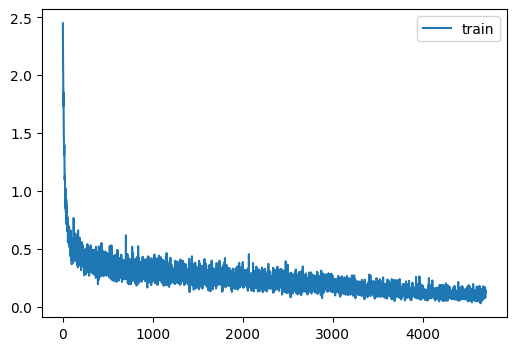

Fit 20 in: 144.04s, setup: 0.00s, 6.90 ± 0.07s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9483


In [49]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)), epochs=20, tta=True)

In [52]:
learn.fit(20,cbs=ProgressCB())

Reseed: 1


accuracy,loss,epoch,train
0.974,0.074,0,train
0.945,0.191,0,eval
0.956,0.121,1,train
0.934,0.203,1,eval
0.943,0.158,2,train
0.931,0.209,2,eval
0.931,0.191,3,train
0.895,0.307,3,eval
0.923,0.215,4,train
0.900,0.301,4,eval


### 94.78 with rotation1 + RandErase 0.3

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.743,0.722,0,train
0.808,0.560,0,eval
0.838,0.436,1,train
0.833,0.538,1,eval
0.861,0.382,2,train
0.782,0.692,2,eval
0.872,0.350,3,train
0.841,0.448,3,eval
0.878,0.334,4,train
0.850,0.456,4,eval


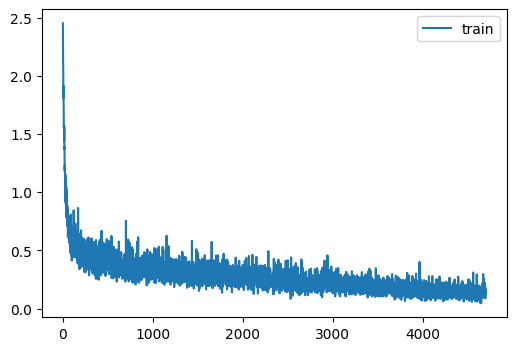

Fit 20 in: 144.28s, setup: 0.00s, 6.91 ± 0.08s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9478


In [53]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)), epochs=20, tta=True)

## New seed (seed205811062)

### 95.27 RandErase 0.2 -rotation -drop_rate (vs dadaptation .07) (seed205811062)

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.782,0.621,0,train
0.858,0.390,0,eval
0.864,0.364,1,train
0.878,0.346,1,eval
0.885,0.316,2,train
0.879,0.331,2,eval
0.892,0.291,3,train
0.881,0.336,3,eval
0.899,0.274,4,train
0.907,0.279,4,eval


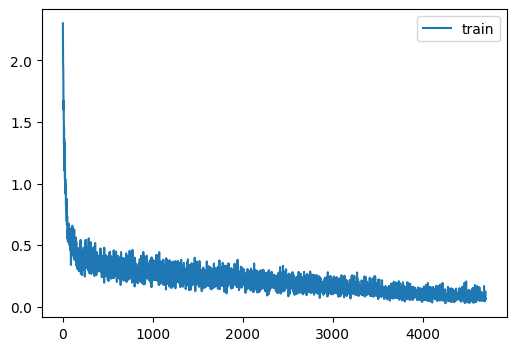

Fit 20 in: 139.51s, setup: 0.00s, 6.67 ± 0.05s per epoch, 0.03 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9527


In [36]:
RNG.set_seed(205811062)
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(0.2)), epochs=20, tta=True)

### 95.27 RandErase 0.2 drop_rate=0.4 -rotation -mixup (vs dadaptation 95.29%) (seed205811062)

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.787,0.609,0,train
0.807,0.542,0,eval
0.873,0.344,1,train
0.850,0.451,1,eval
0.886,0.311,2,train
0.889,0.319,2,eval
0.897,0.284,3,train
0.863,0.392,3,eval
0.902,0.273,4,train
0.893,0.304,4,eval


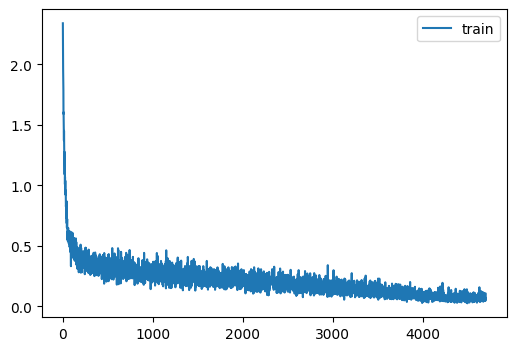

Fit 20 in: 139.57s, setup: 0.00s, 6.68 ± 0.05s per epoch, 0.03 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9527


In [44]:
RNG.set_seed(205811062)
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.1)),
            #opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

### 95.28 AdamW no wd RandErase 0.2 -rotation -drop_rate (vs dadaptation .07) (seed205811062)

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.783,0.620,0,train
0.847,0.419,0,eval
0.865,0.361,1,train
0.866,0.366,1,eval
0.882,0.320,2,train
0.778,0.599,2,eval
0.893,0.288,3,train
0.868,0.356,3,eval
0.900,0.272,4,train
0.837,0.464,4,eval


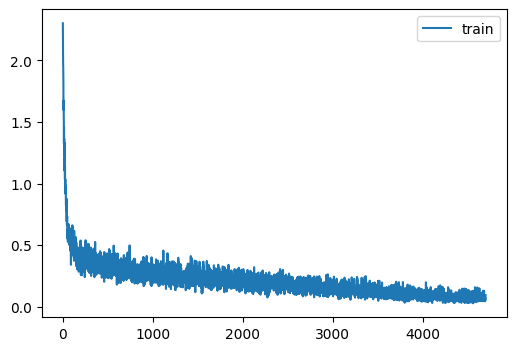

Fit 20 in: 139.55s, setup: 0.00s, 6.68 ± 0.08s per epoch, 0.03 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9528


In [46]:
RNG.set_seed(205811062)
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(0.2)),
            opt_func=partial(optim.AdamW, weight_decay=0.0),
            epochs=20, tta=True)

# dadaptation 

In [23]:
import dadaptation

### Accelerate is as good as Autocast (for mixup) 5ep

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.620,1.036,0,train
0.798,0.629,0,eval
0.853,0.400,1,train
0.843,0.482,1,eval
0.889,0.302,2,train
0.763,0.794,2,eval
0.911,0.244,3,train
0.922,0.225,3,eval
0.921,0.211,4,train
0.929,0.203,4,eval


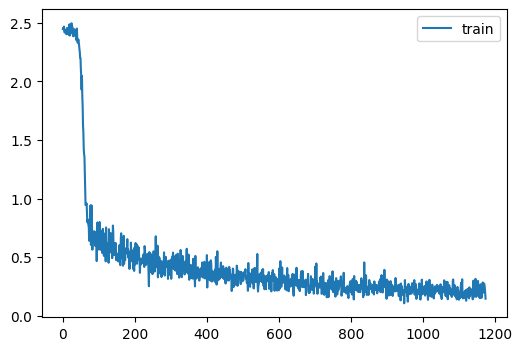

Fit 5 in: 57.49s, setup: 0.00s, 11.15 ± 0.11s per epoch, 0.04 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9296


In [70]:
RNG.set_seed(1)
# does acclerate works as good as autocast
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=AccelerateCB(),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=5, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.620,1.034,0,train
0.835,0.462,0,eval
0.854,0.401,1,train
0.884,0.367,1,eval
0.889,0.302,2,train
0.902,0.278,2,eval
0.911,0.244,3,train
0.922,0.222,3,eval
0.922,0.211,4,train
0.928,0.203,4,eval


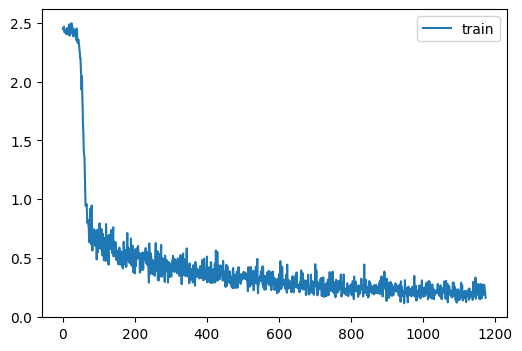

Fit 5 in: 56.67s, setup: 0.00s, 11.03 ± 0.12s per epoch, 0.04 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9296


In [73]:
# does acclerate works as good as autocast
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            #train_cb=AccelerateCB(),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=5, tta=True)

#### DadaptAdam with weight_decay to match AdamW fails to train 84.1

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.715,0.789,0,train
0.811,0.543,0,eval
0.902,0.267,1,train
0.906,0.276,1,eval
0.927,0.198,2,train
0.923,0.214,2,eval
0.947,0.143,3,train
0.936,0.184,3,eval
0.965,0.094,4,train
0.941,0.175,4,eval


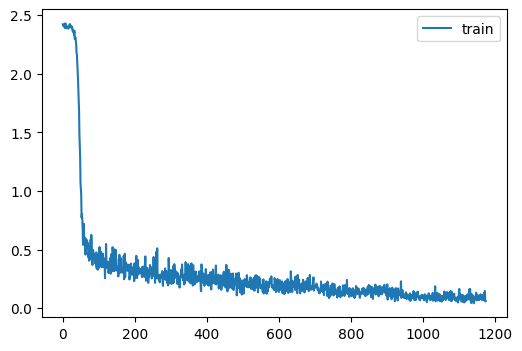

Fit 5 in: 54.42s, setup: 0.00s, 10.58 ± 0.09s per epoch, 0.04 ± 0.01s per batch


In [35]:

RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=0.0),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1)


Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.768,0.644,0,train
0.802,0.580,0,eval
0.898,0.287,1,train
0.903,0.277,1,eval
0.923,0.213,2,train
0.901,0.287,2,eval
0.942,0.156,3,train
0.930,0.195,3,eval
0.960,0.107,4,train
0.936,0.181,4,eval


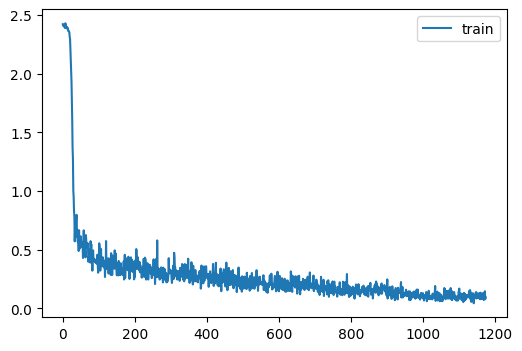

Fit 5 in: 54.52s, setup: 0.00s, 10.60 ± 0.02s per epoch, 0.04 ± 0.00s per batch


In [47]:
import dadaptation
RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=0.0),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=2)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.648,0.980,0,train
0.863,0.377,0,eval
0.882,0.323,1,train
0.877,0.362,1,eval
0.897,0.282,2,train
0.893,0.311,2,eval
0.908,0.253,3,train
0.888,0.328,3,eval
0.914,0.236,4,train
0.895,0.289,4,eval


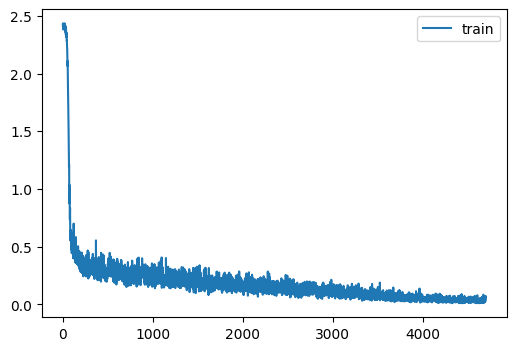

Fit 20 in: 224.81s, setup: 0.00s, 10.94 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9485


In [45]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5)), 
                opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,epochs=20, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.536,1.274,0,train
0.826,0.502,0,eval
0.837,0.440,1,train
0.839,0.528,1,eval
0.863,0.372,2,train
0.839,0.499,2,eval
0.878,0.335,3,train
0.887,0.335,3,eval
0.885,0.314,4,train
0.774,0.701,4,eval


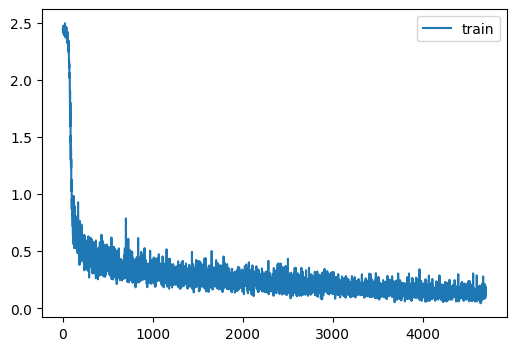

Fit 20 in: 225.86s, setup: 0.00s, 10.99 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9469


In [54]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

## MixUpCB to fight with overfiting on 20ep 

In [18]:
#|export

from miniai.mixup import MixUpCB
class MixUpFP16CB(MixUpCB, AccelerateCB): pass

### 20ep resnet18d does Mixup make sense (drop_rate=0.4) Seed 205811062

#### 94.98% RandErase 0.2 +mixup, -rotation seed1

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.524,1.668,0,train
0.855,0.491,0,eval
0.787,1.173,1,train
0.868,0.414,1,eval
0.811,1.113,2,train
0.864,0.458,2,eval
0.828,1.073,3,train
0.897,0.390,3,eval
0.830,1.061,4,train
0.903,0.385,4,eval


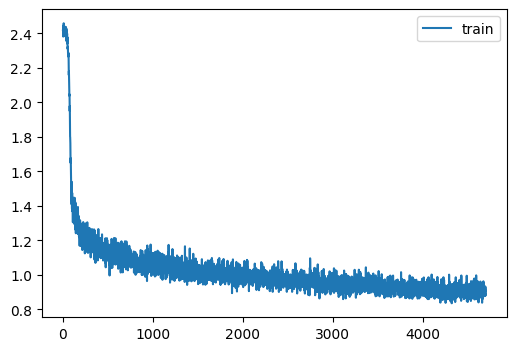

Fit 20 in: 226.60s, setup: 0.00s, 11.02 ± 0.08s per epoch, 0.05 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9498


In [67]:
RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

#### 95.02% RandErase 0.2 +mixup, -rotation seed205811062

Reseed: 205811062
Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.512,1.680,0,train
0.841,0.486,0,eval
0.793,1.165,1,train
0.859,0.466,1,eval
0.811,1.111,2,train
0.896,0.397,2,eval
0.827,1.071,3,train
0.899,0.377,3,eval
0.829,1.058,4,train
0.906,0.328,4,eval


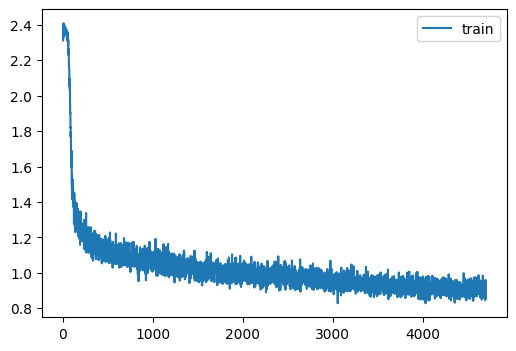

Fit 20 in: 227.35s, setup: 0.00s, 11.04 ± 0.09s per epoch, 0.04 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9502


In [47]:
RNG.set_seed(205811062)
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

#### 95.13% RandErase 0.3, -mixup (seed205811062)

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.509,1.332,0,train
0.742,0.847,0,eval
0.837,0.441,1,train
0.872,0.380,1,eval
0.861,0.379,2,train
0.814,0.608,2,eval
0.877,0.334,3,train
0.893,0.296,3,eval
0.884,0.318,4,train
0.885,0.326,4,eval


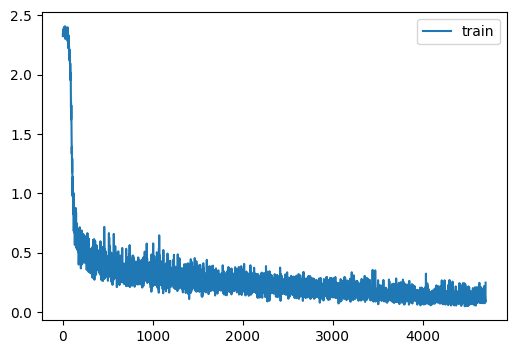

Fit 20 in: 221.00s, setup: 0.00s, 10.75 ± 0.26s per epoch, 0.04 ± 0.01s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9513


In [24]:
RNG.set_seed(205811062)
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

#### 95.29% RandErase 0.2, -mixup (dadaptation .29 vs adamw .27)

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.556,1.210,0,train
0.827,0.468,0,eval
0.859,0.379,1,train
0.871,0.364,1,eval
0.882,0.326,2,train
0.878,0.334,2,eval
0.892,0.296,3,train
0.877,0.361,3,eval
0.902,0.274,4,train
0.912,0.258,4,eval


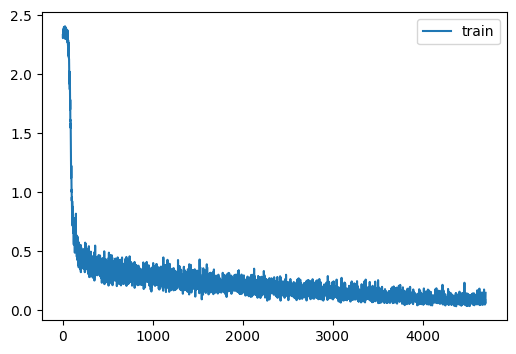

Fit 20 in: 220.87s, setup: 0.00s, 10.74 ± 0.07s per epoch, 0.04 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9529


In [32]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

#### 95.07% RandErase 0.2, -mixup -drop_rate (dadaptation .07 vs AdamW .27) on 20 ep

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.589,1.129,0,train
0.848,0.417,0,eval
0.864,0.365,1,train
0.883,0.339,1,eval
0.886,0.310,2,train
0.881,0.331,2,eval
0.897,0.280,3,train
0.876,0.364,3,eval
0.903,0.261,4,train
0.911,0.256,4,eval


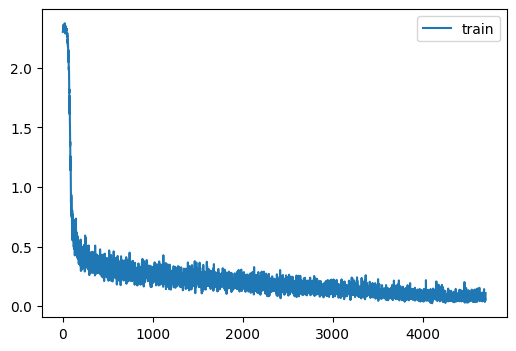

Fit 20 in: 221.21s, setup: 0.00s, 10.76 ± 0.13s per epoch, 0.04 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9507


In [40]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0, ),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

#### 95.3% no mixup randerase 0.1 

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.590,1.124,0,train
0.849,0.417,0,eval
0.873,0.345,1,train
0.851,0.418,1,eval
0.888,0.307,2,train
0.885,0.320,2,eval
0.900,0.275,3,train
0.900,0.283,3,eval
0.906,0.259,4,train
0.912,0.246,4,eval


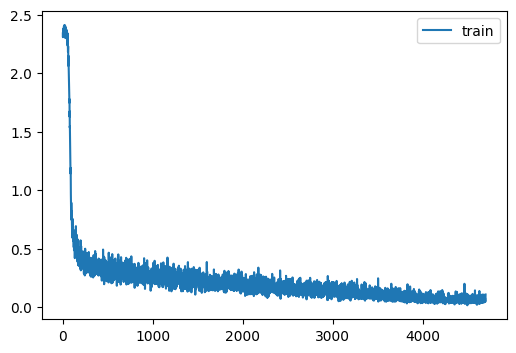

Fit 20 in: 220.31s, setup: 0.00s, 10.71 ± 0.08s per epoch, 0.04 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.953


In [31]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.1)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

### Resnet50d

#### 95.12% no mixup randerase 0.1 resnet50d (overfitting) 521s

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.631,1.031,0,train
0.844,0.443,0,eval
0.861,0.372,1,train
0.861,0.398,1,eval
0.882,0.324,2,train
0.882,0.338,2,eval
0.893,0.293,3,train
0.851,0.484,3,eval
0.903,0.267,4,train
0.882,0.368,4,eval


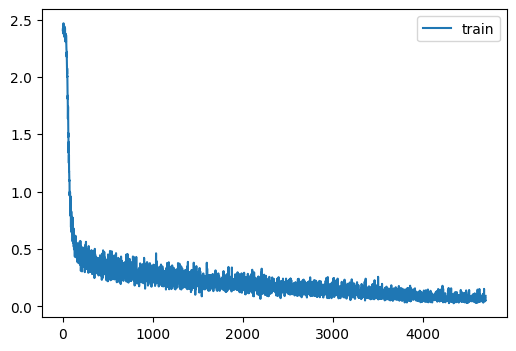

Fit 20 in: 521.49s, setup: 0.00s, 25.35 ± 0.08s per epoch, 0.10 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9512


In [38]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.1)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

#### 95.19% -mixup randerase 0.2 resnet50d 521s (overfit? )

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.597,1.118,0,train
0.830,0.478,0,eval
0.847,0.408,1,train
0.823,0.501,1,eval
0.871,0.353,2,train
0.862,0.398,2,eval
0.884,0.315,3,train
0.845,0.493,3,eval
0.895,0.286,4,train
0.900,0.286,4,eval


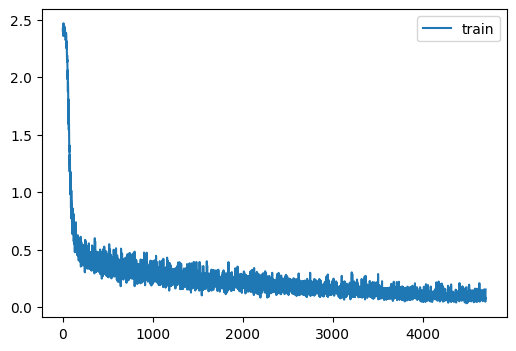

Fit 20 in: 522.34s, setup: 0.00s, 25.39 ± 0.07s per epoch, 0.11 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9519


In [41]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

#### 94.6% +mixup, randerase 0.2 resnet50d 521s

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.530,1.659,0,train
0.821,0.565,0,eval
0.777,1.206,1,train
0.836,0.519,1,eval
0.798,1.151,2,train
0.816,0.592,2,eval
0.814,1.106,3,train
0.884,0.447,3,eval
0.825,1.074,4,train
0.904,0.386,4,eval


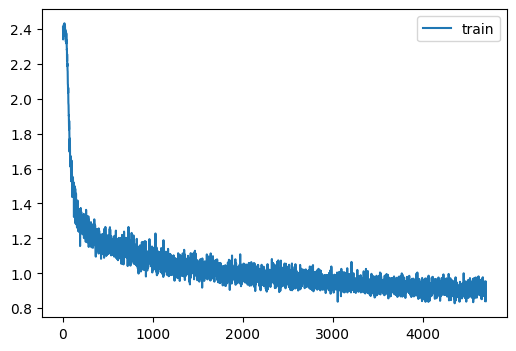

Fit 20 in: 529.96s, setup: 0.00s, 25.74 ± 0.07s per epoch, 0.11 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.946


In [45]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

#### 95.08 -mixup, randerase 0.3 

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.549,1.239,0,train
0.788,0.644,0,eval
0.824,0.473,1,train
0.820,0.538,1,eval
0.848,0.411,2,train
0.805,0.650,2,eval
0.871,0.354,3,train
0.827,0.542,3,eval
0.880,0.330,4,train
0.869,0.399,4,eval


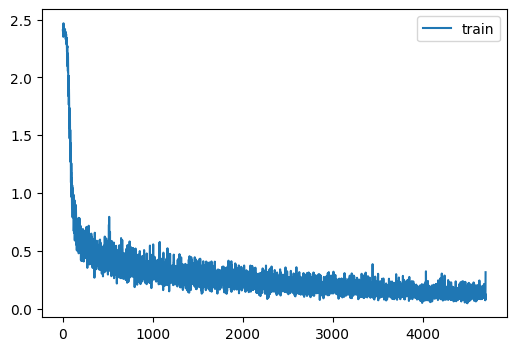

Fit 20 in: 521.74s, setup: 0.00s, 25.35 ± 0.08s per epoch, 0.10 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9508


In [49]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

#### 94.91 -mixup, drop_rate 0.5 

Reseed: 205811062
Batch size 256
Reseed: 205811062


accuracy,loss,epoch,train
0.533,1.276,0,train
0.779,0.624,0,eval
0.821,0.480,1,train
0.832,0.488,1,eval
0.848,0.415,2,train
0.839,0.510,2,eval
0.867,0.361,3,train
0.809,0.568,3,eval
0.879,0.334,4,train
0.858,0.461,4,eval


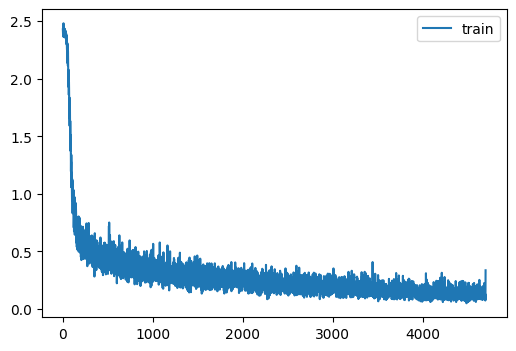

Fit 20 in: 522.29s, setup: 0.00s, 25.38 ± 0.09s per epoch, 0.11 ± 0.00s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9491


In [51]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.5),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

### 94.75% seed1 -mixup, drop_rate 0.4, RandErase 0.3

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.546,1.240,0,train
0.787,0.615,0,eval
0.825,0.470,1,train
0.795,0.628,1,eval
0.847,0.416,2,train
0.821,0.557,2,eval
0.868,0.361,3,train
0.865,0.420,3,eval
0.880,0.324,4,train
0.867,0.414,4,eval


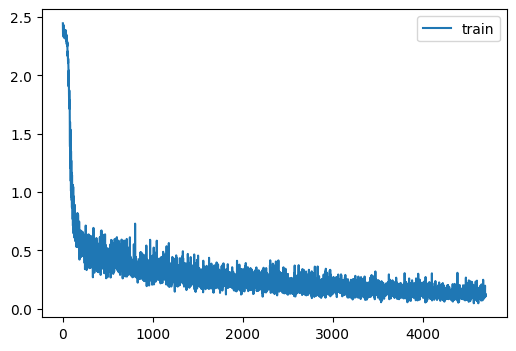

Fit 20 in: 523.03s, setup: 0.00s, 25.41 ± 0.09s per epoch, 0.11 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9475


In [53]:
RNG.set_seed(1)
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.567,1.172,0,train
0.331,4.250,0,eval
0.659,0.919,1,train
0.334,2.390,1,eval
0.728,0.733,2,train
0.352,3.375,2,eval
0.779,0.593,3,train
0.767,0.626,3,eval
0.824,0.484,4,train
0.841,0.423,4,eval


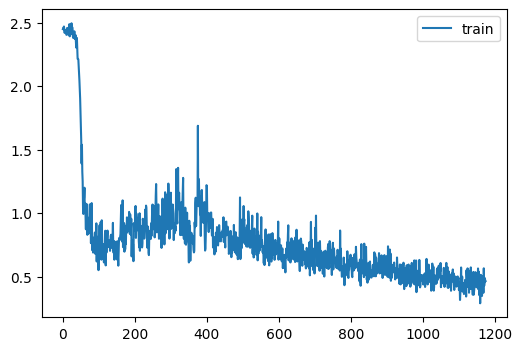

Fit 5 in: 57.99s, setup: 0.00s, 11.29 ± 0.08s per epoch, 0.05 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.8444


In [75]:
# what weight decay will do to DadaptAdam, (it matches Adam then), I remember it being worse for DadaptAdam and better for Adam
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=AccelerateCB(),
            opt_func=partial(dadaptation.DAdaptAdam,weight_decay=0.001), base_lr=1,
            epochs=5, tta=True)

### 50 ep 95.63% 18d and 95.82% 50d

#### resnet18d 95.6 (mixup, randerase=0.2)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.514,1.686,0,train
0.842,0.491,0,eval
0.789,1.173,1,train
0.881,0.417,1,eval
0.811,1.116,2,train
0.874,0.417,2,eval
0.826,1.081,3,train
0.904,0.380,3,eval
0.830,1.063,4,train
0.905,0.349,4,eval


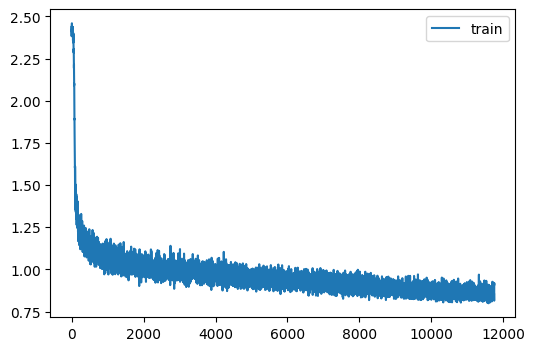

Fit 50 in: 567.19s, setup: 0.00s, 11.01 ± 0.05s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.956


In [76]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

#### resnet50d 95.82 (mixup, randerase=0.2)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.519,1.678,0,train
0.824,0.534,0,eval
0.772,1.215,1,train
0.869,0.442,1,eval
0.797,1.151,2,train
0.874,0.414,2,eval
0.814,1.114,3,train
0.890,0.391,3,eval
0.818,1.098,4,train
0.890,0.408,4,eval


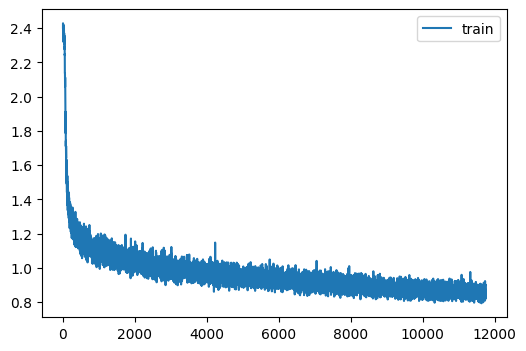

Fit 50 in: 1322.20s, setup: 0.00s, 25.69 ± 0.08s per epoch, 0.11 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9582


In [97]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

In [115]:
#save(learn, "resnet50d_50ep_mixup.pkl")

#### resnet18d 95.63 (mixup, randerase=0.1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.562,1.609,0,train
0.857,0.490,0,eval
0.810,1.128,1,train
0.891,0.390,1,eval
0.826,1.084,2,train
0.874,0.429,2,eval
0.839,1.051,3,train
0.901,0.363,3,eval
0.843,1.038,4,train
0.899,0.363,4,eval


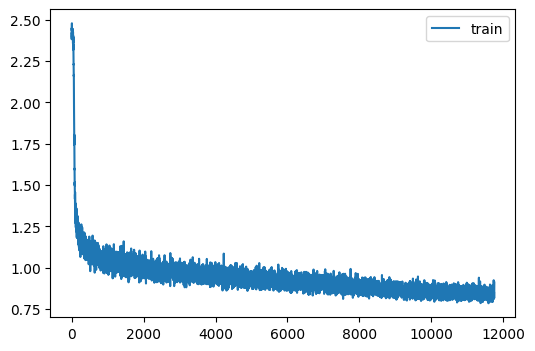

Fit 50 in: 565.24s, setup: 0.00s, 10.97 ± 0.06s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9563


In [ ]:
# to save mixup20, and test if randerase from 0.2 to 0.1 is better #0.9563, compared to #0.956
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.1)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

In [121]:
#save(learn, "resnet18d_50ep_mixup_smallerase.pkl")

# More exotic modifications that are poor

## Fail - general relu or hardshwish is better with resnet18d

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.837,0.472,0,train
0.815,0.575,0,eval
0.900,0.271,1,train
0.868,0.379,1,eval
0.922,0.211,2,train
0.899,0.276,2,eval
0.944,0.153,3,train
0.924,0.210,3,eval
0.963,0.101,4,train
0.942,0.170,4,eval


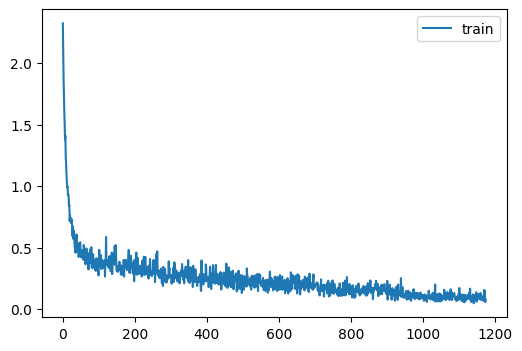

Fit 5 in: 33.80s, setup: 0.00s, 6.46 ± 0.11s per epoch, 0.03 ± 0.01s per batch


In [ ]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=None))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.833,0.493,0,train
0.637,1.348,0,eval
0.899,0.278,1,train
0.894,0.301,1,eval
0.921,0.216,2,train
0.908,0.248,2,eval
0.942,0.155,3,train
0.934,0.187,3,eval
0.963,0.103,4,train
0.939,0.176,4,eval


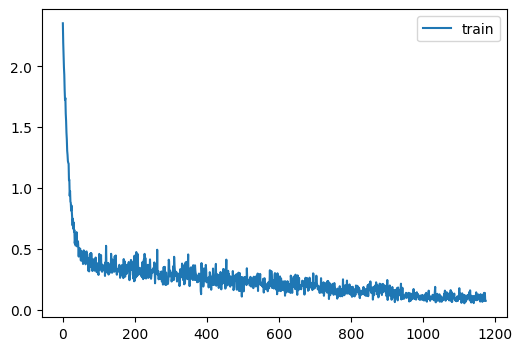

Fit 5 in: 34.68s, setup: 0.00s, 6.62 ± 0.13s per epoch, 0.03 ± 0.01s per batch


In [ ]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), act_layer=lambda inplace:GeneralRelu(leak=0.1, sub=0.4), 
            leaky=0.1, ))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.819,0.533,0,train
0.682,1.283,0,eval
0.902,0.268,1,train
0.888,0.327,1,eval
0.925,0.204,2,train
0.906,0.266,2,eval
0.945,0.148,3,train
0.935,0.188,3,eval
0.965,0.095,4,train
0.940,0.173,4,eval


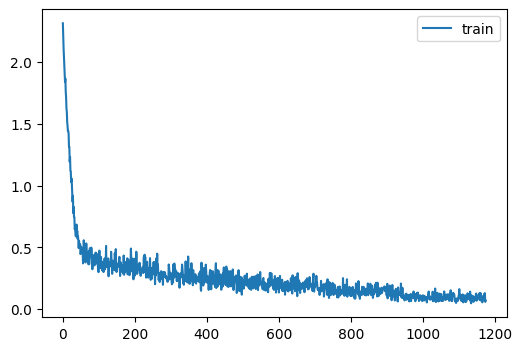

Fit 5 in: 34.96s, setup: 0.00s, 6.66 ± 0.15s per epoch, 0.03 ± 0.01s per batch


In [ ]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), act_layer=nn.Hardswish, 
            leaky=0.0003, ))

## Fail - Augment with curriculum

Reseed: 1
duplicate key cbs 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.802,0.563,0,train
0.822,0.529,0,eval
0.878,0.334,1,train
0.850,0.429,1,eval
0.907,0.252,2,train
0.912,0.238,2,eval
0.925,0.199,3,train
0.929,0.197,3,eval
0.942,0.157,4,train
0.936,0.179,4,eval


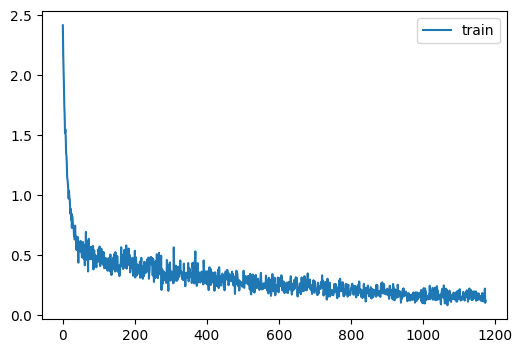

Fit 5 in: 35.44s, setup: 0.01s, 6.76 ± 0.16s per epoch, 0.03 ± 0.01s per batch


In [40]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929), transforms.RandomHorizontalFlip(0.5)),
            curriculum())

Reseed: 1
duplicate key cbs 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.833,0.483,0,train
0.874,0.374,0,eval
0.874,0.342,1,train
0.896,0.288,1,eval
0.908,0.250,2,train
0.917,0.228,2,eval
0.928,0.195,3,train
0.929,0.194,3,eval
0.942,0.154,4,train
0.937,0.173,4,eval


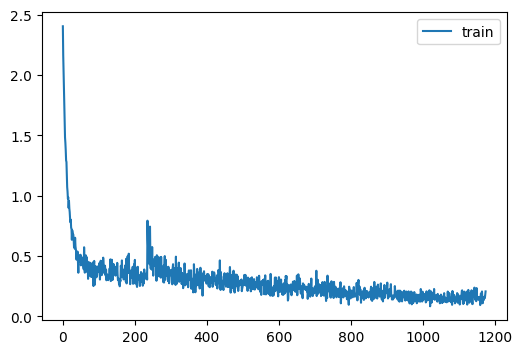

Fit 5 in: 35.25s, setup: 0.00s, 6.73 ± 0.10s per epoch, 0.03 ± 0.01s per batch


In [42]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929), transforms.RandomHorizontalFlip(0.5), delay=1),
            curriculum())

Reseed: 1
duplicate key cbs 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.833,0.483,0,train
0.874,0.374,0,eval
0.885,0.314,1,train
0.893,0.300,1,eval
0.913,0.236,2,train
0.910,0.253,2,eval
0.933,0.185,3,train
0.931,0.187,3,eval
0.948,0.141,4,train
0.939,0.172,4,eval


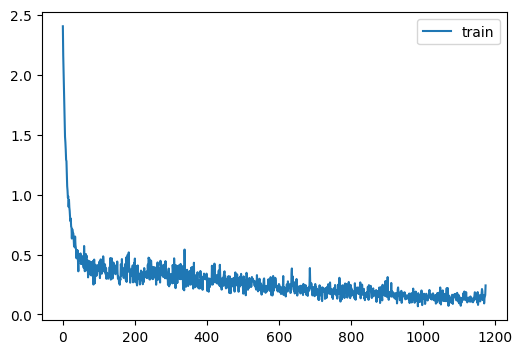

Fit 5 in: 35.36s, setup: 0.00s, 6.74 ± 0.11s per epoch, 0.03 ± 0.01s per batch


In [44]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929), delay=1),
            curriculum())

# Export

In [24]:
import nbdev; nbdev.nbdev_export()